In [ ]:
#default_exp radardsp

In [ ]:
#hide
import matplotlib.pyplot as plt

from radicalsdk.h5dataset import H5DatasetLoader
from radicalsdk.radar.config_v1 import read_radar_params
from radicalsdk.radar.v1 import RadarFrame

radar_config = read_radar_params('../samples/indoor_human_rcs.cfg')
rf = RadarFrame(radar_config)

data = H5DatasetLoader('../samples/indoor_sample_50.h5', ['radar'])
raw_radar = next(iter(data))[0]

2022-06-09 16:03:09.778672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 16:03:09.778727: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# radardsp

Blocks in FMCW radar signal processing chain

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

import numpy as np
from mmwave import dsp

In [ ]:
#export

def cfar_nms(cfar_in, beamformed_ra, nhood_size=1):
    """non-maxumim suppression for cfar detections"""
    def get_nhood(xx, yy):
        return beamformed_ra[yy-nhood_size:yy+nhood_size+1, xx-nhood_size:xx+nhood_size+1]
    
    nms_arr = np.zeros_like(cfar_in)
 
    for yy, xx in zip(*np.where(cfar_in == 1)):
        nms_arr[yy, xx] = 1 if np.all(beamformed_ra[yy, xx] >= get_nhood(xx, yy)) else 0
    
    return nms_arr

def range_azimuth_ca_cfar(beamformed_radar_cube, nms=True):
    """Cell-Averaging CFAR on beamformed radar signal
    
    inputs:
      - `beamformed_radar_cube`
      - `nms`: default `True` whether to perform non-maximum suppression
    """
    range_az = np.abs(beamformed_radar_cube)
    heatmap_log = np.log2(range_az)

    first_pass, _ = np.apply_along_axis(func1d=dsp.cago_,
                                        axis=0,
                                        arr=heatmap_log,
                                        l_bound=1.5,
                                        guard_len=4,
                                        noise_len=16)

    # --- cfar in range direction
    second_pass, noise_floor = np.apply_along_axis(func1d=dsp.caso_,
                                                   axis=0,
                                                   arr=heatmap_log.T,
                                                   l_bound=3,
                                                   guard_len=4,
                                                   noise_len=16)

    # --- classify peaks and caclulate snrs
    SKIP_SIZE = 4
    noise_floor = noise_floor.T
    first_pass = (heatmap_log > first_pass)
    second_pass = (heatmap_log > second_pass.T)
    peaks = (first_pass & second_pass)
    peaks[:SKIP_SIZE, :] = 0
    peaks[-SKIP_SIZE:, :] = 0
    peaks[:, :SKIP_SIZE] = 0
    peaks[:, -SKIP_SIZE:] = 0

    peaks = peaks.astype('float32')

    if nms:
        peaks = peaks * cfar_nms(peaks, range_az, 1)
        
    return peaks

In [ ]:
# export

def range_azimuth_os_cfar(beamformed_datacube,
                          k=4,
):
    """
    Ordered-statistics CFAR

    beamformed_datacube: radar datacube
    k: which ordered statistic to use
    """

    # --- preprocess
    range_az = np.abs(beamformed_datacube)
    heatmap_log = np.log2(range_az)

    # --- cfar in azimuth direction
    first_pass, _ = np.apply_along_axis(func1d=dsp.os_,
                                        axis=0,
                                        arr=heatmap_log,
                                        k=k,
                                        scale=1.1,
                                        guard_len=4,
                                        noise_len=3)

    # --- cfar in range direction
    second_pass, noise_floor = np.apply_along_axis(func1d=dsp.os_,
                                                   axis=0,
                                                   arr=heatmap_log.T,
                                                   k=k,
                                                   scale=1.1,
                                                   guard_len=4,
                                                   noise_len=3)

    SKIP_SIZE = 4
    noise_floor = noise_floor.T
    first_pass = (heatmap_log > first_pass)
    second_pass = (heatmap_log > second_pass.T)
    peaks = (first_pass & second_pass)
    peaks[:SKIP_SIZE, :] = 0
    peaks[-SKIP_SIZE:, :] = 0
    peaks[:, :SKIP_SIZE] = 0
    peaks[:, -SKIP_SIZE:] = 0

    peaks = peaks.astype('float32')

    return peaks
    

# Example Usage

## Basic usage for Cell-Averaging CFAR

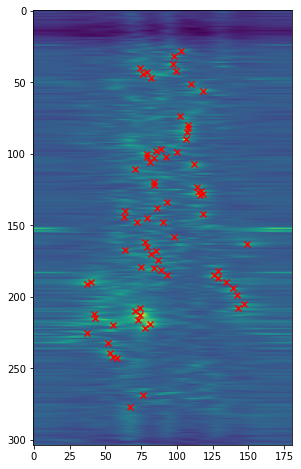

In [ ]:
beamformed_range_azimuth = rf.compute_range_azimuth(raw_radar)
ca_cfar_detections = range_azimuth_ca_cfar(beamformed_range_azimuth)

plt.figure(figsize=(5, 8))
plt.imshow(np.log(np.abs(beamformed_range_azimuth)))
plt.scatter(np.where(ca_cfar_detections == 1)[1], np.where(ca_cfar_detections == 1)[0], marker='x', c='r')
plt.show()

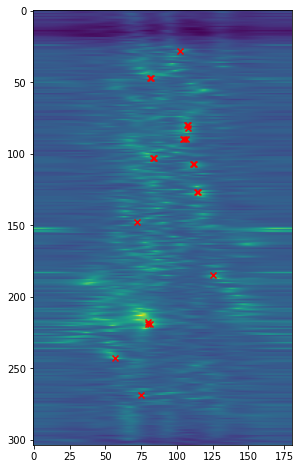

In [ ]:
os_cfar_detections = range_azimuth_os_cfar(beamformed_range_azimuth)

plt.figure(figsize=(5, 8))
plt.imshow(np.log(np.abs(beamformed_range_azimuth)))
plt.scatter(np.where(os_cfar_detections == 1)[1], np.where(os_cfar_detections == 1)[0], marker='x', c='r')
plt.show()